In [215]:
import pyspark
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sbn
import pandas as pd
import datetime

%matplotlib inline

plt.style.use('default') 

sbn.set(style="whitegrid") 

# **Apertura de archivos a usar durante la resolucion del trabajo practico.**

In [216]:
postulaciones_educacion = pd.read_csv('fiuba_1_postulantes_educacion.csv')
postulaciones_genero_edad = pd.read_csv('fiuba_2_postulantes_genero_y_edad.csv')
vistas = pd.read_csv('fiuba_3_vistas.csv')
postulaciones = pd.read_csv('fiuba_4_postulaciones.csv')
avisos_online = pd.read_csv('fiuba_5_avisos_online.csv')
avisos_detalle = pd.read_csv('fiuba_6_avisos_detalle.csv')

# Preparando los datos para el analisis

## Archivo 'postulaciones'

In [217]:
postulaciones.isnull().any()

idaviso             False
idpostulante        False
fechapostulacion    False
dtype: bool

In [218]:
#Creo columnas para poder utilizar la fecha y el horario mas comodamente, en el archivo de Postulaciones
postulaciones['date'] = pd.to_datetime(postulaciones['fechapostulacion']).dt.date
postulaciones['time'] = pd.to_datetime(postulaciones['fechapostulacion']).dt.time
postulaciones.head()

,idaviso,idpostulante,fechapostulacion,date,time
0,1112257047,NM5M,2018-01-15 16:22:34,2018-01-15,16:22:34
1,1111920714,NM5M,2018-02-06 09:04:50,2018-02-06,09:04:50
2,1112346945,NM5M,2018-02-22 09:04:47,2018-02-22,09:04:47
3,1112345547,NM5M,2018-02-22 09:04:59,2018-02-22,09:04:59
4,1112237522,5awk,2018-01-25 18:55:03,2018-01-25,18:55:03


In [219]:
print(postulaciones.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3401623 entries, 0 to 3401622
Data columns (total 5 columns):
idaviso             int64
idpostulante        object
fechapostulacion    object
date                object
time                object
dtypes: int64(1), object(4)
memory usage: 129.8+ MB
None


In [220]:
#Veo si hay filas duplicadas con los mismos valores en todas las columnas
postulaciones.duplicated().any()

False

## Archivo 'avisos_detalle'

In [221]:
avisos_detalle.isnull().any()

idaviso                 False
idpais                  False
titulo                  False
descripcion             False
nombre_zona             False
ciudad                   True
mapacalle                True
tipo_de_trabajo         False
nivel_laboral           False
nombre_area             False
denominacion_empresa     True
dtype: bool

In [222]:
#ESTE DF TIENE DATOS NULOS EN LAS COLUMNAS DE 'CIUDAD', 'MAPACALLE' Y 'DENOMINACION_EMPRESA'. 
#Decidimos eliminarlas ya que no nos parecieron muy relevantes para el analisis
avisos_detalle.drop(['ciudad','mapacalle','denominacion_empresa','descripcion'],1,inplace=True)
#avisos_detalle.drop('descripcion',1,inplace=True)

In [223]:
#Asi quedaria finalmente el archivo 'avisos_detalle' para el analisis
avisos_detalle.head()

,idaviso,idpais,titulo,nombre_zona,tipo_de_trabajo,nivel_laboral,nombre_area
0,8725750,1,VENDEDOR/A PROVINCIA DE SANTA FE,Gran Buenos Aires,Full-time,Senior / Semi-Senior,Comercial
1,17903700,1,Enfermeras,Gran Buenos Aires,Full-time,Senior / Semi-Senior,Salud
2,1000150677,1,Chofer de taxi,Capital Federal,Full-time,Senior / Semi-Senior,Transporte
3,1000610287,1,CHOFER DE CAMIONETA BAHIA BLANCA - PUNTA ALTA,Gran Buenos Aires,Full-time,Senior / Semi-Senior,Transporte
4,1000872556,1,Operarios de Planta - Rubro Electrodomésticos,Gran Buenos Aires,Full-time,Senior / Semi-Senior,Producción


## Archivo 'postulaciones_genero_edad'

In [224]:
postulaciones_genero_edad.isnull().any()

idpostulante       False
fechanacimiento     True
sexo               False
dtype: bool

In [225]:
# Parece ser que es una proporción importante de las postulaciones
# las que no incluyen fecha de nacimiento
postulaciones_genero_edad['fechanacimiento'].isnull().sum()

4750

In [226]:
#Veo si hay filas duplicadas con los mismos valores en todas las columnas
postulaciones_genero_edad.duplicated().any()

False

In [227]:
#Veo si hay usuarios duplicados
postulaciones_genero_edad['idpostulante'].duplicated().any()

False

In [228]:
#En primer instancia le asignamos el año actual, para poder comenzar con el analisis.
postulaciones_genero_edad = postulaciones_genero_edad.fillna(2018-1-1)
postulaciones_genero_edad.isnull().any()

idpostulante       False
fechanacimiento    False
sexo               False
dtype: bool

## Archivo 'postulaciones_educacion'

In [229]:
postulaciones_educacion.head()

,idpostulante,nombre,estado
0,NdJl,Posgrado,En Curso
1,8BkL,Universtario,En Curso
2,1d2B,Universitario,En Curso
3,NPBx,Universitario,En Curso
4,NPBx,Master,En Curso


In [230]:
#Veo si hay filas de datos duplicados
postulaciones_educacion.isnull().any()

idpostulante    False
nombre          False
estado          False
dtype: bool

In [231]:
# Hay ids de postulantes duplicados, lo que es consistente con que un postulante tenga en su perfil
# por ejemplo, un estudio universitario en curso y un estudio secundario completo
postulaciones_educacion.duplicated(subset = 'idpostulante').any()

True

## Archivo 'vistas'

In [232]:
vistas.head()
# Plantea la relación entre postulantes y avisos

,idAviso,timestamp,idpostulante
0,1111780242,2018-02-23T13:38:13.187-0500,YjVJQ6Z
1,1112263876,2018-02-23T13:38:14.296-0500,BmVpYoR
2,1112327963,2018-02-23T13:38:14.329-0500,wVkBzZd
3,1112318643,2018-02-23T13:38:17.921-0500,OqmP9pv
4,1111903673,2018-02-23T13:38:18.973-0500,DrpbXDP


In [233]:
vistas.isnull().any()

idAviso         False
timestamp       False
idpostulante    False
dtype: bool

In [234]:
vistas.duplicated().any()

False

## Arichivo 'avisos_online'

In [235]:
avisos_online.isnull().any()

idaviso    False
dtype: bool

In [236]:
avisos_online.duplicated().any()

False

# Algunas exploraciones de cada archivo por separado

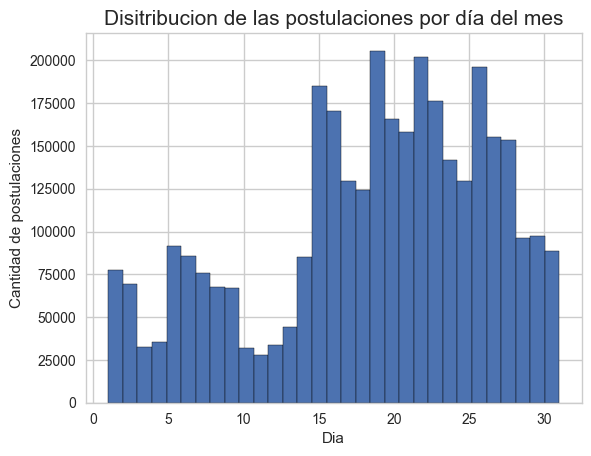

In [237]:
#Distribución de las postulaciones por dia del mes
g_day = pd.to_datetime(postulaciones['date']).dt.day.hist(bins=31,edgecolor='black');
g_day.set_title('Disitribucion de las postulaciones por día del mes',fontsize=15)
g_day.set_xlabel('Dia')
g_day.set_ylabel('Cantidad de postulaciones');

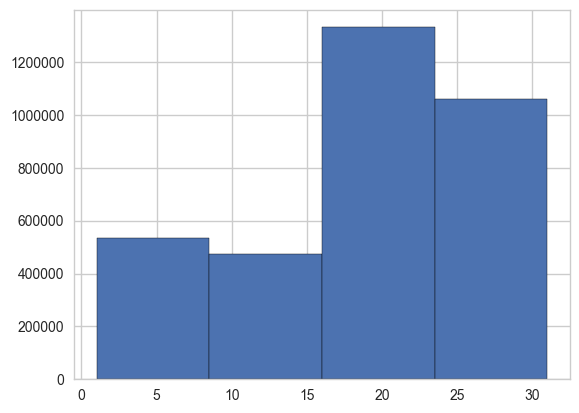

In [238]:
# ¿Será que uno se pone a buscar trabajo cuando se le empieza a acabar el sueldo?
g_day = pd.to_datetime(postulaciones['date']).dt.day.hist(bins=4,edgecolor='black');

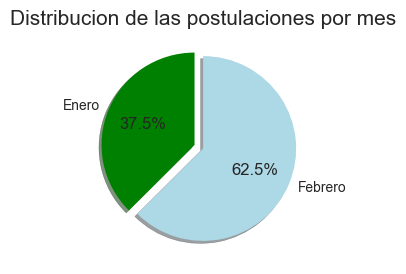

In [239]:
enero = postulaciones['date'][pd.to_datetime(postulaciones['date']).dt.month == 1]
enero = pd.DataFrame(enero)

febrero = postulaciones['date'][pd.to_datetime(postulaciones['date']).dt.month == 2]
febrero = pd.DataFrame(febrero)

sizes = [enero.count(),febrero.count()]
names = ['Enero', 'Febrero']

plt.figure(figsize=(3, 3))
plt.title('Distribucion de las postulaciones por mes', fontsize=15)
plt.pie(sizes, labels=names, autopct='%1.1f%%', startangle=90, colors=['green', 'lightblue'], explode=(0.1, 0),shadow=True)
plt.show()

In [240]:
# ¡Los datos empiezan a partir del 15/1!
postulaciones['date'].min()

datetime.date(2018, 1, 15)

Ambos graficos son engañosos.
El primero muestra que hay mas postulaciones en la segunda mitad de los meses pero eso es porque los datos de Enero son solo de la segunda mitad del mes.
De igual manera el sugundo grafico muestra que Enero tiene practicamente la mitad de postulaciones que Febrero.
Tambien se debe a lo comentado anteriormente, solo hay datos de la segunda mitad de Enero.

In [241]:
#Febrero tiene (casi)los dias completos
febrero = postulaciones['date'][pd.to_datetime(postulaciones['date']).dt.month == 2]
febrero = pd.DataFrame(febrero.unique()).sort_values(by=0, ascending=False)
febrero

,0
6,2018-02-28
10,2018-02-27
13,2018-02-26
26,2018-02-25
25,2018-02-24
15,2018-02-23
1,2018-02-22
9,2018-02-21
20,2018-02-20
5,2018-02-19


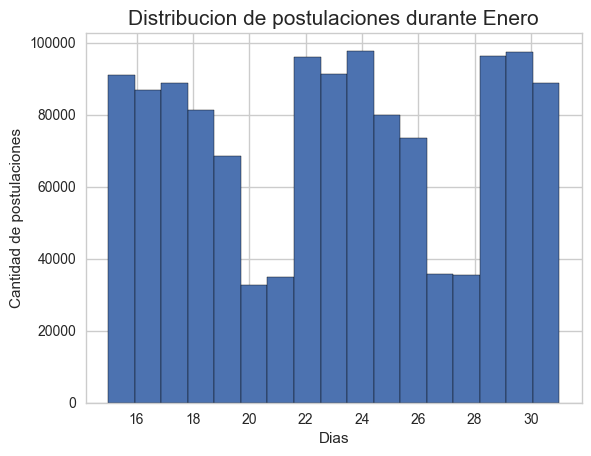

In [242]:
g_month_enero = pd.to_datetime(postulaciones['date'][pd.to_datetime(postulaciones['date']).dt.month == 1]).dt.day.hist(bins=17,edgecolor='black');
g_month_enero.set_title('Distribucion de postulaciones durante Enero',fontsize=15)
g_month_enero.set_xlabel('Dias')
g_month_enero.set_ylabel('Cantidad de postulaciones');

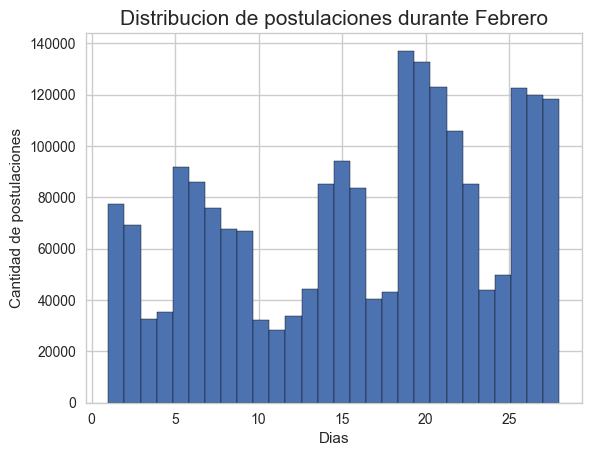

In [243]:
g_month_febrero = pd.to_datetime(postulaciones['date'][pd.to_datetime(postulaciones['date']).dt.month == 2]).dt.day.hist(bins=28,edgecolor='black');
g_month_febrero.set_title('Distribucion de postulaciones durante Febrero',fontsize=15)
g_month_febrero.set_xlabel('Dias')
g_month_febrero.set_ylabel('Cantidad de postulaciones');

Ambos gráficos presentan 'bajones' de 2-3 días de duración: ¿Son fines de semana?

Ambos gráficos presentan 'bajones' de 2-3 días de duración: ¿Son fines de semana

Ambos gráficos presentan 'bajones' de 2-3 días de duración: ¿Son fines de semana

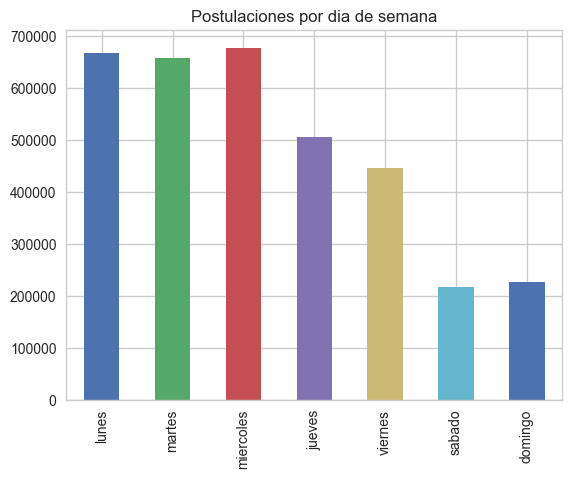

In [244]:
postulaciones['weekday']= pd.to_datetime(postulaciones['date']).dt.dayofweek
days = ['lunes','martes','miercoles','jueves','viernes','sabado','domingo']
postulaciones['weekday'] = pd.Categorical(values=postulaciones['weekday'].values, ordered=True).rename_categories(days)
postulaciones['weekday'].value_counts().sort_index().plot(kind='bar', title='Postulaciones por dia de semana')
# Al hacer el gráfico, podemos ver que los fines de semana tienen muchas menos postulaciones
# y que jueves y viernes son los dias de la semana con menos postulaciones.

In [245]:
#este df contiene solo los dias entre el 15 y 28 de cada mes
enero_febrero_igual_dias = pd.DataFrame(columns = ['date'])
enero_febrero_igual_dias['date'] = postulaciones['date'][(pd.to_datetime(postulaciones['date']).dt.day > 14) & (pd.to_datetime(postulaciones['date']).dt.day < 29)]

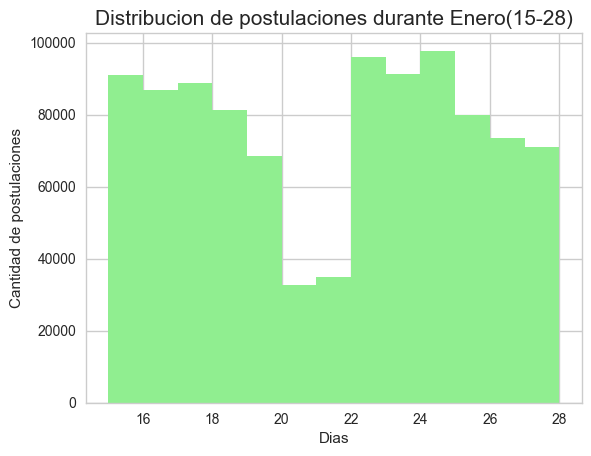

In [246]:
hist_enero_edit = pd.to_datetime(enero_febrero_igual_dias['date'][pd.to_datetime(enero_febrero_igual_dias['date']).dt.month == 1]).dt.day.hist(bins=13,color= 'lightgreen');
hist_enero_edit.set_title('Distribucion de postulaciones durante Enero(15-28)',fontsize=15)
hist_enero_edit.set_xlabel('Dias')
hist_enero_edit.set_ylabel('Cantidad de postulaciones');

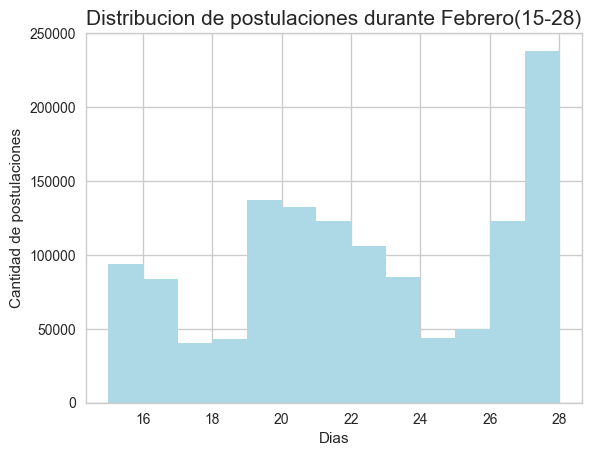

In [247]:
hist_Febrero_edit = pd.to_datetime(enero_febrero_igual_dias['date'][pd.to_datetime(enero_febrero_igual_dias['date']).dt.month == 2]).dt.day.hist(bins=13,color='lightblue');
hist_Febrero_edit.set_title('Distribucion de postulaciones durante Febrero(15-28)',fontsize=15)
hist_Febrero_edit.set_xlabel('Dias')
hist_Febrero_edit.set_ylabel('Cantidad de postulaciones');

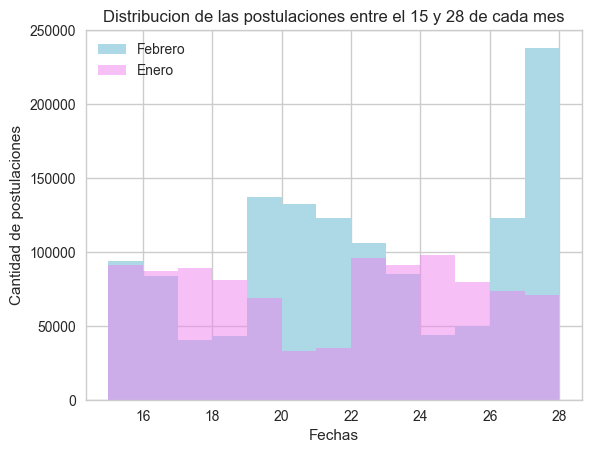

In [248]:
plt.hist(pd.to_datetime(enero_febrero_igual_dias['date']
        [pd.to_datetime(enero_febrero_igual_dias['date']).dt.month == 2]).dt.day, bins=13,
         color='lightblue',label= 'Febrero')
plt.hist(pd.to_datetime(enero_febrero_igual_dias['date']
        [pd.to_datetime(enero_febrero_igual_dias['date']).dt.month == 1]).dt.day,bins=13,
         color='violet',alpha=0.5, label='Enero')
plt.xlabel('Fechas')
plt.ylabel('Cantidad de postulaciones')
plt.title('Distribucion de las postulaciones entre el 15 y 28 de cada mes')
plt.legend()
plt.show()

De esta última comparación se aprecia que el número de postulaciones es en general
mayor para febrero, y que el último día de febrero presenta un pico muy alto en 
las postulaciones.

In [249]:
postulaciones_educacion.head()

,idpostulante,nombre,estado
0,NdJl,Posgrado,En Curso
1,8BkL,Universtario,En Curso
2,1d2B,Universitario,En Curso
3,NPBx,Universitario,En Curso
4,NPBx,Master,En Curso


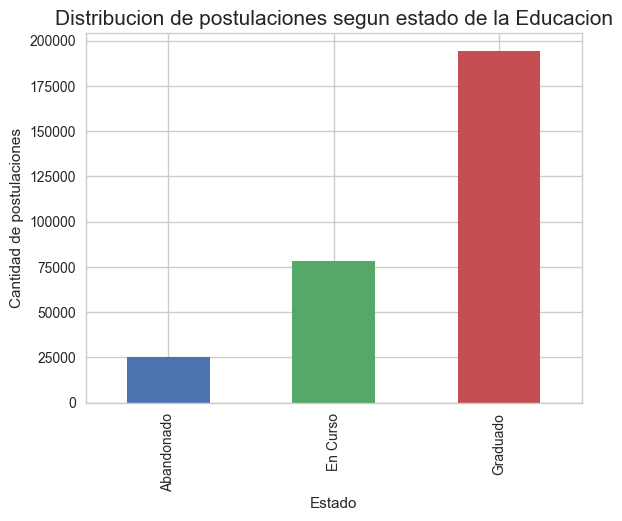

In [250]:
post_educ_estado = postulaciones_educacion['estado'].value_counts().sort_index().plot(kind='bar')
post_educ_estado.set_title('Distribucion de postulaciones segun estado de la Educacion',fontsize=15)
post_educ_estado.set_xlabel('Estado')
post_educ_estado.set_ylabel('Cantidad de postulaciones');

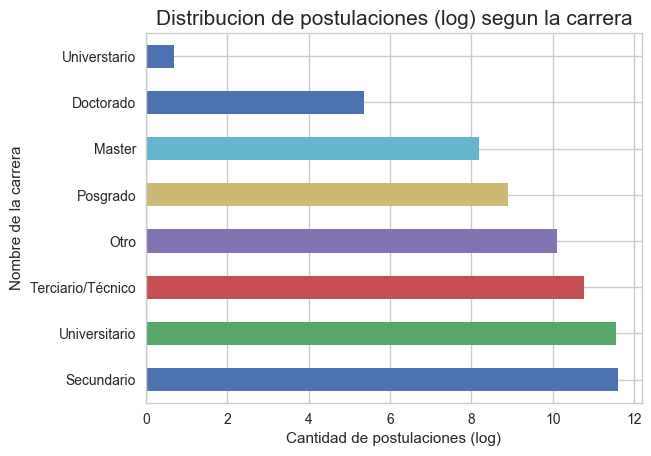

In [251]:
post_educ_carrera = np.log(postulaciones_educacion['nombre'].value_counts() + 1).plot(kind='barh')
post_educ_carrera.set_title('Distribucion de postulaciones (log) segun la carrera',fontsize=15)
post_educ_carrera.set_ylabel('Nombre de la carrera')
post_educ_carrera.set_xlabel('Cantidad de postulaciones (log)');

ValueError: shape mismatch: objects cannot be broadcast to a single shape

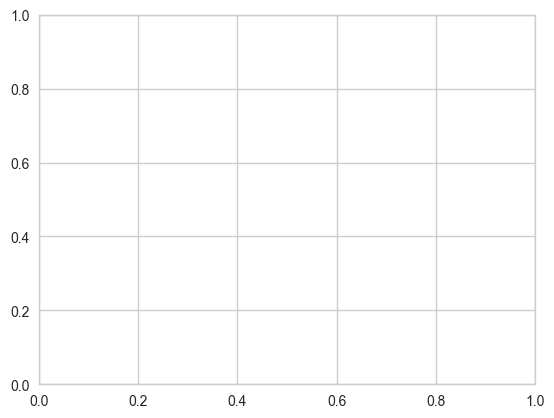

In [252]:
estado_y_carreras = postulaciones_educacion[['nombre','estado']]
benchs_number = 7
benchs_names = ['Doctorado','Master','Otro','Posgrado','Secundario', 'Terciario/Tecnico','Universitario']

arch_en_curso = estado_y_carreras[estado_y_carreras['estado'] == 'En Curso']
arch_graduado = estado_y_carreras[estado_y_carreras['estado'] == 'Graduado']
arch_abandonado = estado_y_carreras[estado_y_carreras['estado'] == 'Abandonado']

#Uso una escala logaritmica asi se pueden ver mejor los datos en el grafico
en_curso = np.log(arch_en_curso['nombre'].value_counts() +1).sort_index()
abandonado = np.log(arch_abandonado['nombre'].value_counts() +1).sort_index()
graduado = np.log(arch_graduado['nombre'].value_counts() +1).sort_index()

index = np.arange(len(benchs_names))

bar_width = 0.2
opacity = 0.5

plt.barh(index, en_curso, bar_width, alpha=0.7,color='y',label='En Curso',)
plt.barh(index+bar_width, abandonado, bar_width, alpha=0.7,color='r',label='Abandonado')
plt.barh(index+2*bar_width, graduado, bar_width, alpha=0.7,color='g',label='Graduado')

plt.grid(True, axis='x', linewidth=0.2)
plt.title('Distribucion de postulaciones (log) segun el estado de cada carrera',fontsize = 15)
plt.ylabel('Carreras')
plt.xlabel('Cantidad de postulaciones (log)')
plt.yticks(index + 2*bar_width, benchs_names)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:

postulaciones_genero_edad['edad'] = pd.to_datetime(postulaciones_genero_edad['fechanacimiento'],errors='coerce').dt.year
postulaciones_genero_edad['edad'] = 2018 - postulaciones_genero_edad['edad']
postulaciones_genero_edad.sort_values(by='edad', ascending=True)

In [ ]:
postulaciones_genero_edad.fillna(0)
edad_postulantes = pd.DataFrame(columns=['edad'])
edad_postulantes['edad'] = postulaciones_genero_edad['edad'][(postulaciones_genero_edad['edad'] > 17) & (postulaciones_genero_edad['edad'] < 71)]
edad_postulantes['edad'] = edad_postulantes['edad'].astype(int)
edad_postulantes.sort_values(by='edad', ascending = True)

In [ ]:
postulaciones_genero_edad = postulaciones_genero_edad.fillna(0)
postulaciones_genero_edad['edad'] = postulaciones_genero_edad['edad'].astype(int)
postulaciones_genero_edad = postulaciones_genero_edad[(postulaciones_genero_edad['edad'] <71) & (postulaciones_genero_edad['edad'] > 17)]
postulaciones_genero_edad.head()

In [ ]:
post_genero = postulaciones_genero_edad['sexo'].value_counts().plot(kind='barh')
post_genero.set_title('Distribucion de postulaciones segun el genero',fontsize=15)
post_genero.set_ylabel('Genero')
post_genero.set_xlabel('Cantidad de postulaciones');

In [ ]:
post_edad = edad_postulantes['edad'].value_counts().sort_index().plot(kind='line',color='green')
post_edad.set_title('Distribucion de postulaciones segun la edad de los postulantes',fontsize=15)
post_edad.set_xlabel('Edad')
post_edad.set_ylabel('Cantidad de postulaciones');



In [ ]:
femenino = pd.DataFrame(columns = ['genero','edad'])
masculino = pd.DataFrame(columns = ['genero','edad'])
no_declara = pd.DataFrame(columns = ['genero','edad'])

femenino = postulaciones_genero_edad[postulaciones_genero_edad['sexo'] == 'FEM']
masculino = postulaciones_genero_edad[postulaciones_genero_edad['sexo'] == 'MASC']
no_declara = postulaciones_genero_edad[postulaciones_genero_edad['sexo'] == 'NO_DECLARA']

#plt.hist(femenino['edad'], bins=53, color='pink',label= 'Postulantes Fememinas')
#plt.hist(masculino['edad'], bins=53, color='darkblue',alpha=0.3, label='Postulantes Masculinos')
#plt.hist(no_declara['edad'], bins=53, color='red',alpha=0.5, label='Postulantes sin sexo declarado')

plt.xlabel('Edad')
plt.ylabel('Cantidad de postulaciones')
plt.title('Distribucion de las postulaciones segun edad y el genero')
plt.legend()
plt.show()

In [ ]:
#Cantidad de postulaciones de personas que no declaran su sexo segun su edad.
no_declara['edad'].value_counts().head()

In [ ]:
avisos_detalle.head()

In [ ]:
#avisos_nivel_laboral = avisos_detalle['nivel_laboral'].value_counts().plot(kind='bar')
#avisos_nivel_laboral.set_title('Distribucion de los avisos laborales segun el nivel laboral pedido',fontsize=15)
#avisos_nivel_laboral.set_xlabel('Cantidad de avisos')
#avisos_nivel_laboral.set_ylabel('Nivel laboral');

avisos_detalle['nivel_laboral'].value_counts()

In [ ]:
avisos_tipo_de_trabajo = np.log(avisos_detalle['tipo_de_trabajo'].value_counts()+1).plot(kind='barh')
avisos_tipo_de_trabajo.set_title('Distribucion de los avisos (log) laborales segun el tipo de trabajo pedido',fontsize=15)
avisos_tipo_de_trabajo.set_ylabel('Tipo de trabajo')
avisos_tipo_de_trabajo.set_xlabel('Cantidad de avisos (log)');

avisos_detalle['tipo_de_trabajo'].value_counts().sum()

In [ ]:
avisos_zona = np.log(avisos_detalle['nombre_zona'].value_counts() + 1).sort_index().plot(kind='bar')
avisos_zona.set_title('Distribucion de los avisos laborales segun la zona de trabajo',fontsize=15)
avisos_zona.set_xlabel('Zona')
avisos_zona.set_ylabel('Cantidad de avisos (log)');

avisos_detalle['nombre_zona'].value_counts()

# Merge de los datos
recuerdo la forma de los datasets

In [253]:
#vistas = vistas.set_index()
vistas['idpostulante'].value_counts()

dYJV5K2    595
8MaQjP3    556
dYoRZw0    521
QNrKkvl    451
DrXRjZK    414
8Mrr8dM    411
E6ZlW8     407
Oqr14Ov    370
5OON3M     351
OqjNZ2x    349
6rP3KZO    348
dYoPxP2    323
1PLkJz     319
zvaVLqK    311
Oqm4Zb8    308
W9kYGYm    292
BmBN1rv    286
BmZxxQv    264
ZPz9K5     260
EQPm1b     256
MVrXO83    255
96XNwzw    253
pzMA89M    251
eko8jeW    250
ow2vrqj    248
GNXeZRp    241
8MrG1OR    240
bO4lj8E    236
VNkl3NR    235
BmamxYQ    234
          ... 
zv6qr6D      1
8MBLp0O      1
owaoJ50      1
wVXap6m      1
jkjzVWG      1
12V8Wb       1
NzPRjQx      1
rmRl5Gx      1
LNKNja5      1
5D5GYG       1
Nz0xPvl      1
ewOVoE       1
bOJJB09      1
MVrlGY3      1
pzek0JM      1
jkdMGaY      1
OqPzwG6      1
MVPr4Jx      1
NqKQoL       1
dY92mZY      1
1Kd9N        1
KBeoGE2      1
OqdXRm3      1
PmJK0Ga      1
dY53JDD      1
X95Q0dQ      1
6rPEQ0R      1
akjO45m      1
0zPar5d      1
Dr63Xrd      1
Name: idpostulante, Length: 87443, dtype: int64

In [261]:
postulaciones_educacion.head(15)

,idpostulante,nombre,estado
0,NdJl,Posgrado,En Curso
1,8BkL,Universtario,En Curso
2,1d2B,Universitario,En Curso
3,NPBx,Universitario,En Curso
4,NPBx,Master,En Curso
5,Ym2X,Otro,En Curso
6,ZKl5,Master,En Curso
7,EDD99,Terciario/Técnico,En Curso
8,Y043Z,Universitario,En Curso
9,6M3jr,Universitario,En Curso


In [302]:
postulantes = postulaciones_genero_edad.set_index('idpostulante')
postulantes['anuncios_vistos'] = vistas['idpostulante'].value_counts()
postulantes['anuncios_vistos'] = postulantes['anuncios_vistos'].fillna(0)
#sobresimplificación horrible, habría que ponderar más fuerte estudios avanzados y estudios completos.
postulantes['nivel_educativo'] = postulaciones_educacion['idpostulante'].value_counts()

postulantes.head(10)

,fechanacimiento,sexo,anuncios_vistos,nivel_educativo
idpostulante,,,,
NM5M,1970-12-03,FEM,0.0,1.0
5awk,1962-12-04,FEM,26.0,2.0
ZaO5,1978-08-10,FEM,1.0,2.0
NdJl,1969-05-09,MASC,7.0,2.0
eo2p,1981-02-16,MASC,0.0,4.0
Ez8J,1968-12-18,MASC,4.0,1.0
aOQq,1966-07-16,MASC,5.0,1.0
8BkL,1976-07-21,FEM,8.0,4.0
1d2B,1976-02-28,MASC,0.0,1.0


Text(0,0.5,'Cantidad de postulantes(log)')

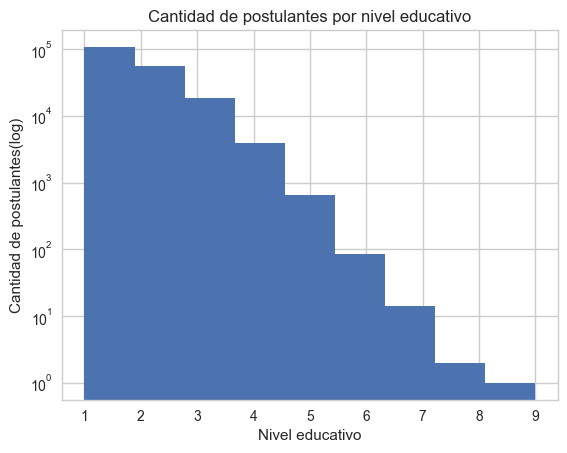

In [323]:
hist_educacion = postulantes['nivel_educativo'].hist(log=True, bins=9, label='cantidad de postulantes por nivel educativo')
hist_educacion.set_title('Cantidad de postulantes por nivel educativo')
hist_educacion.set_xlabel('Nivel educativo')
hist_educacion.set_ylabel('Cantidad de postulantes(log)')

Text(0,0.5,'Cantidad de anuncios vistos por postulante(log)')

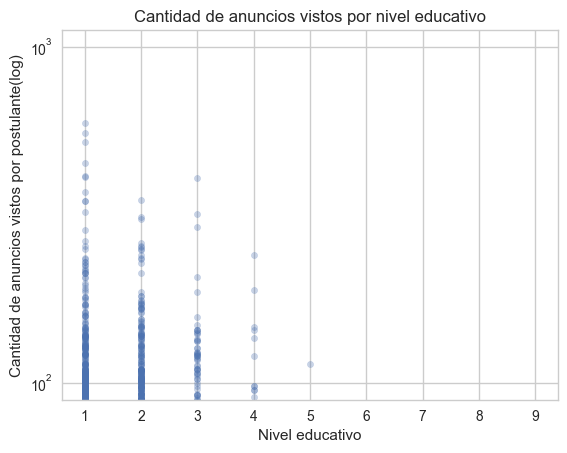

In [329]:
scatter_anuncios_vistos = postulantes.plot.scatter('nivel_educativo','anuncios_vistos', logy=True,alpha=0.3)
scatter_anuncios_vistos.set_title('Cantidad de anuncios vistos por nivel educativo')
scatter_anuncios_vistos.set_xlabel('Nivel educativo')
scatter_anuncios_vistos.set_ylabel('Cantidad de anuncios vistos por postulante(log)')

Text(0,0.5,'Promedio de anuncios vistos')

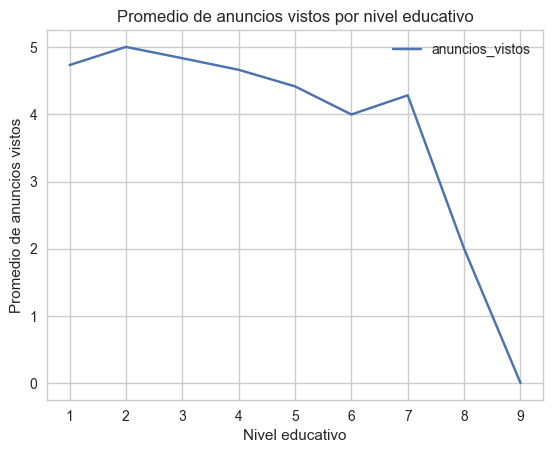

In [346]:
bar_avg_anuncios_vistos = postulantes.groupby('nivel_educativo').agg(np.average).plot()
bar_avg_anuncios_vistos.set_title('Promedio de anuncios vistos por nivel educativo')
bar_avg_anuncios_vistos.set_xlabel('Nivel educativo')
bar_avg_anuncios_vistos.set_ylabel('Promedio de anuncios vistos')


In [ ]:
postulaciones['anuncios_vistos'] = vistas['idpostulante'].value_counts()
postulaciones.head()

In [ ]:
avisos_online.head()

In [ ]:
postulaciones_educacion.head()

In [ ]:
#MERGE PARA VER LOS AVISOS ONLINE Y OFFLINE VISTOS POR POSTULANTES
avisos_vistos_por_postulantes = pd.merge(vistas, postulaciones_genero_edad, on='idpostulante', how='inner')
avisos_vistos_por_postulantes.groupby('idpostulante').agg(np.sum)

In [ ]:
#RENOMBRO LA COLUMNA 'idAviso' DEL DF VISTAS PARA QUE COINCIDA CON EL DE AVISOS_ONLINE
vistas = vistas.rename(columns={'idAviso':'idaviso'})

In [ ]:
#HAGO UN MERGE PARA VER SOLO LOS AVISOS ONLINE QUE HALLAN SIDO VISTOS
avisos_online_vistos = pd.merge(vistas, avisos_online, on='idaviso', how='inner')

In [ ]:
#Hacer un merge con con los datos de el estado de las carreras y los sexos
postulantes_educacion_genero = pd.merge(postulaciones_genero_edad, postulaciones_educacion, on='idpostulante', how='inner')
postulantes_educacion_genero.head()